In [1]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
#import plotly.express as px

from pandas_profiling import ProfileReport
from sklearn import metrics
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer


In [2]:
KAGGLE_EVAL_METRIC = 'logloss' # string name for loss function in xgboost

In [3]:
TRAIN_PATH = "data/train.csv"
TEST_PATH = "data/test.csv"

# Load Data

In [4]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

In [5]:
target = ["Survived"]

In [6]:
## Bring in Age Predictions

In [7]:
age_pred = pd.read_csv('data/age_predictions.csv')

age_pred = age_pred[['PassengerId','is_child']]

train = train.merge(age_pred, on='PassengerId', how='left')
train['is_child'] = np.where(train['is_child'].isnull() == True, train['Age'], train['is_child'])
train['is_child'] = np.where(train['is_child'] < 10, 1,0)
#train = train.drop(['age_pediction'],axis=1)

#test = test.merge(age_pred, on='PassengerId', how='left')
#test['Age'] = np.where(test['Age'].isnull() == True, test['age_pediction'],test['Age'])
#test = test.drop(['age_pediction'],axis=1)

In [8]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_child
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,0
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,0


# Pre-Processing3

# NLP STUFF

### Names

In [9]:
## Helper functions
def get_nickanme(x):
    if "(" in x:
        nickname = re.findall('\(.*?\)',x)[0]
    elif '"' in x:
        nickname = re.findall('\".*?\"',x)[0]
    else:
        nickname = "none"
    return nickname

def get_lastname(name, first_name, title, nickname):
    last_name = name.replace(first_name,'')
    last_name = last_name.replace(title,'')
    last_name = last_name.replace(nickname,'')
    last_name = last_name.replace(',','')
    return last_name

def replace_last(source_string, replace_what):
    head, _sep, tail = source_string.rpartition(replace_what)
    return head + "" + tail


In [10]:
def nlp_transforms(df):
    df.Name = df.Name.str.lower()

    ## first name, title, nickname
    df['First Name'] = df['Name'].apply(lambda x: x.split(",")[0])
    df['Title'] = df['Name'].apply(lambda x: x.split(",")[1].split()[0])
    df['Nickname'] = df['Name'].apply(lambda x: get_nickanme(x))
    df['Last Name'] = df.apply(lambda x: get_lastname(x['Name'], x['First Name'],x['Title'],x['Nickname']), axis=1)
    df['Junior'] = df['Last Name'].apply(lambda x: x.endswith(("jr","ii")))
    df['Last Name'] = df['Last Name'].apply(lambda x: replace_last(x, "jr"))
    df['Last Name'] = df['Last Name'].apply(lambda x: replace_last(x, "ii"))
    df['Last Name'] = df['Last Name'].apply(lambda x: x.strip())
    df['Middle Names'] = df['Last Name'].apply(lambda x: x.split(' ')[1:])
    df['Middle Names'] = df['Middle Names'].apply(lambda x: ' '.join(x))
    df['Last Name'] = df['Last Name'].apply(lambda x: x.split(' ')[0])
    return df

In [11]:
train = nlp_transforms(train)
test = nlp_transforms(test)

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_child,First Name,Title,Nickname,Last Name,Junior,Middle Names
0,1,0,3,"braund, mr. owen harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,braund,mr.,none,owen,False,harris
1,2,1,1,"cumings, mrs. john bradley (florence briggs th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0,cumings,mrs.,(florence briggs thayer),john,False,bradley
2,3,1,3,"heikkinen, miss. laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,heikkinen,miss.,none,laina,False,
3,4,1,1,"futrelle, mrs. jacques heath (lily may peel)",female,35.0,1,0,113803,53.1000,C123,S,0,futrelle,mrs.,(lily may peel),jacques,False,heath
4,5,0,3,"allen, mr. william henry",male,35.0,0,0,373450,8.0500,NaN,S,0,allen,mr.,none,william,False,henry


In [13]:
train[train['First Name'] == 'aks']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_child,First Name,Title,Nickname,Last Name,Junior,Middle Names
855,856,1,3,"aks, mrs. sam (leah rosen)",female,18.0,0,1,392091,9.35,NaN,S,0,aks,mrs.,(leah rosen),sam,False,


In [14]:
train[ (train['SibSp'] == 0) & (train['Parch'] == 0)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_child,First Name,Title,Nickname,Last Name,Junior,Middle Names
2,3,1,3,"heikkinen, miss. laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,heikkinen,miss.,none,laina,False,
4,5,0,3,"allen, mr. william henry",male,35.0,0,0,373450,8.0500,NaN,S,0,allen,mr.,none,william,False,henry
5,6,0,3,"moran, mr. james",male,NaN,0,0,330877,8.4583,NaN,Q,1,moran,mr.,none,james,False,
6,7,0,1,"mccarthy, mr. timothy j",male,54.0,0,0,17463,51.8625,E46,S,0,mccarthy,mr.,none,timothy,False,j
11,12,1,1,"bonnell, miss. elizabeth",female,58.0,0,0,113783,26.5500,C103,S,0,bonnell,miss.,none,elizabeth,False,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"sutehall, mr. henry jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S,0,sutehall,mr.,none,henry,True,
886,887,0,2,"montvila, rev. juozas",male,27.0,0,0,211536,13.0000,NaN,S,0,montvila,rev.,none,juozas,False,
887,888,1,1,"graham, miss. margaret edith",female,19.0,0,0,112053,30.0000,B42,S,0,graham,miss.,none,margaret,False,edith
889,890,1,1,"behr, mr. karl howell",male,26.0,0,0,111369,30.0000,C148,C,0,behr,mr.,none,karl,False,howell


In [15]:
train['family_size'] = train['SibSp'] + train['Parch'] + 1
train['is_alone'] = 0
train.loc[train['family_size'] == 1, 'is_alone'] = 1

In [16]:
train.groupby('First Name')

In [17]:
train[train['First Name'] == 'skoog']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,is_child,First Name,Title,Nickname,Last Name,Junior,Middle Names,family_size,is_alone
63,64,0,3,"skoog, master. harald",male,4.0,3,2,347088,27.9,...,S,1,skoog,master.,none,harald,False,,6,0
167,168,0,3,"skoog, mrs. william (anna bernhardina karlsson)",female,45.0,1,4,347088,27.9,...,S,0,skoog,mrs.,(anna bernhardina karlsson),william,False,,6,0
360,361,0,3,"skoog, mr. wilhelm",male,40.0,1,4,347088,27.9,...,S,0,skoog,mr.,none,wilhelm,False,,6,0
634,635,0,3,"skoog, miss. mabel",female,9.0,3,2,347088,27.9,...,S,1,skoog,miss.,none,mabel,False,,6,0
642,643,0,3,"skoog, miss. margit elizabeth",female,2.0,3,2,347088,27.9,...,S,1,skoog,miss.,none,margit,False,elizabeth,6,0
819,820,0,3,"skoog, master. karl thorsten",male,10.0,3,2,347088,27.9,...,S,0,skoog,master.,none,karl,False,thorsten,6,0


In [18]:
train.groupby('First Name').count().sort_values(by='Name', ascending=False)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,is_child,Title,Nickname,Last Name,Junior,Middle Names,family_size,is_alone
First Name,,,,,,,,,,,,,,,,,,,,
andersson,9,9,9,9,9,9,9,9,9,9,0,9,9,9,9,9,9,9,9,9
sage,7,7,7,7,7,0,7,7,7,7,0,7,7,7,7,7,7,7,7,7
goodwin,6,6,6,6,6,6,6,6,6,6,0,6,6,6,6,6,6,6,6,6
johnson,6,6,6,6,6,6,6,6,6,6,0,6,6,6,6,6,6,6,6,6
skoog,6,6,6,6,6,6,6,6,6,6,0,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hegarty,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
heikkinen,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
heininen,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


### Tickets

In [19]:
def replace_number(ticket, number):
    x = ticket.replace(str(number), '')
    return x

def ticket_transforms(df):
    df.Ticket = df.Ticket.str.lower()

    df['temp'] = df.Ticket.str.split()
    df['Ticket Number'] = df.temp.apply(lambda x: x[-1])
    df["Ticket Number"] = df["Ticket Number"].str.replace('line','0')
    df["Ticket Number"] = df["Ticket Number"].astype(int)
    df['Ticket Type'] = df.apply(lambda x: replace_number(x['Ticket'], x['Ticket Number']), axis=1)
    df = df.drop(['temp'],axis=1)
    return df

In [20]:
train = ticket_transforms(train)
test = ticket_transforms(test)

In [21]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,First Name,Title,Nickname,Last Name,Junior,Middle Names,family_size,is_alone,Ticket Number,Ticket Type
0,1,0,3,"braund, mr. owen harris",male,22.0,1,0,a/5 21171,7.2500,...,braund,mr.,none,owen,False,harris,2,0,21171,a/5
1,2,1,1,"cumings, mrs. john bradley (florence briggs th...",female,38.0,1,0,pc 17599,71.2833,...,cumings,mrs.,(florence briggs thayer),john,False,bradley,2,0,17599,pc
2,3,1,3,"heikkinen, miss. laina",female,26.0,0,0,ston/o2. 3101282,7.9250,...,heikkinen,miss.,none,laina,False,,1,1,3101282,ston/o2.
3,4,1,1,"futrelle, mrs. jacques heath (lily may peel)",female,35.0,1,0,113803,53.1000,...,futrelle,mrs.,(lily may peel),jacques,False,heath,2,0,113803,
4,5,0,3,"allen, mr. william henry",male,35.0,0,0,373450,8.0500,...,allen,mr.,none,william,False,henry,1,1,373450,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"montvila, rev. juozas",male,27.0,0,0,211536,13.0000,...,montvila,rev.,none,juozas,False,,1,1,211536,
887,888,1,1,"graham, miss. margaret edith",female,19.0,0,0,112053,30.0000,...,graham,miss.,none,margaret,False,edith,1,1,112053,
888,889,0,3,"johnston, miss. catherine helen ""carrie""",female,NaN,1,2,w./c. 6607,23.4500,...,johnston,miss.,"""carrie""",catherine,False,helen,4,0,6607,w./c.
889,890,1,1,"behr, mr. karl howell",male,26.0,0,0,111369,30.0000,...,behr,mr.,none,karl,False,howell,1,1,111369,


## Define Features and Target

In [22]:
## helper to build feature list
categorical_features = ['Pclass','Name','Sex','Ticket','Cabin','Embarked','Title','Junior','Nickname','Last Name','Ticket Type','is_child','First Name','is_alone','family_size']
numeric_features = ['Age','SibSp','Parch','Fare','Ticket Number', 'Cabin']

def feature_selection(drop_cols, categorical_cols, ordinal_cols):
    for column in drop_cols:
        if column in categorical_cols: categorical_cols.remove(column)
        if column in ordinal_cols: ordinal_cols.remove(column)
    features = categorical_features + numeric_features
    return features,categorical_features,numeric_features

In [25]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'is_child',
       'First Name', 'Title', 'Nickname', 'Last Name', 'Junior',
       'Middle Names', 'family_size', 'is_alone', 'Ticket Number',
       'Ticket Type'],
      dtype='object')

In [26]:
to_drop = ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'SibSp',
       'Parch', 'Ticket', 'Cabin', 'Embarked', 'is_child',
        'Title', 'Nickname', 'Last Name', 'Junior',
       'Middle Names', 'family_size', 'is_alone', 'Ticket Number',
       'Ticket Type']

In [27]:
features,categorical_features,numeric_features = feature_selection(to_drop,categorical_features,numeric_features)

In [28]:
X = train.drop(to_drop, axis=1)
y = train['Survived']

In [29]:
X

,Age,Fare,First Name
0,22.0,7.2500,braund
1,38.0,71.2833,cumings
2,26.0,7.9250,heikkinen
3,35.0,53.1000,futrelle
4,35.0,8.0500,allen
...,...,...,...
886,27.0,13.0000,montvila
887,19.0,30.0000,graham
888,NaN,23.4500,johnston
889,26.0,30.0000,behr


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [31]:
X_train
#drop_columns = ["PassengerId","Parch","Name","Nickname","Survived"]

,Age,Fare,First Name
501,21.0,7.7500,canavan
743,24.0,16.1000,mcnamee
722,34.0,13.0000,gillespie
856,45.0,164.8667,wick
708,22.0,151.5500,cleaver
...,...,...,...
518,36.0,26.0000,angle
429,32.0,8.0500,pickard
444,NaN,8.1125,johannesen-bratthammer
785,25.0,7.2500,harmer


## Pipeline

In [32]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [33]:
numeric_features

['Age', 'Fare']

In [34]:
categorical_features

['First Name']

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [36]:
XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8, gamma=0.9,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=4,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=2000, n_jobs=None, nthread=-1,
              num_parallel_tree=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=1, subsample=0.8,
              tree_method=None, validate_parameters=None, verbosity=None)

In [39]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(max_depth=4,
                                                    min_child_weight=1,
                                                    learning_rate=0.05,
                                                    n_estimators=100,
                                                    silent=True,
                                                    objective='binary:logistic',
                    ))])

In [40]:
model.fit(X_train, y_train)

[21:33:05] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:33:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncod

In [41]:
y_pred = model.predict(X_test)

In [42]:
y_pred

array([0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0])

In [43]:
print(metrics.accuracy_score(y_test, y_pred))

0.6983240223463687


In [1259]:
print(metrics.accuracy_score(y_test, y_pred))

0.8156424581005587


In [1079]:
def feature_selection(drop_cols, categorical_cols, ordinal_cols):
    for column in drop_cols:
        if column in categorical_cols: categorical_cols.remove(column)
        if column in ordinal_cols: ordinal_cols.remove(column)
    features = categorical_cols + ordinal_cols
    return features

In [490]:
features = feature_selection(drop_columns,categorical,ordinal)

In [491]:
train = train[features] 
test = test[features]

---

Combine train + test to ensure they receive the same preproccessing (category indexs)

In [492]:
train['label'] = 'train'
test['label'] = 'test'

to_clean = train.append(test)

---

## NULLS
To start we'll use XGBOOST and let the algo deal with nulll.
- Age: 
- SibSpa
- Parch
- Fare:
- Embark: 

Future iterations, we can improve score by doing a better job with our NULL values.

In [493]:
#train = train.fillna(-1)
#test = test.fillna(-1)

--- 

## Categorical Data
Transform categorical features to integer representatins

In [494]:
# categorical encoding
def objects_to_category(df):
    '''
    function that converts objects to categorical features.
    '''
    object_cols = df.columns.tolist()
    object_features = df[object_cols].astype("category")
    for field in object_cols:
        df[field] = object_features[field].cat.codes
    return df

to_clean[categorical] = objects_to_category(to_clean[categorical])
to_clean[categorical] = objects_to_category(to_clean[categorical])

<ipython-input-494-e4c6efef39e0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[field] = object_features[field].cat.codes


In [1658]:
to_clean.head()

,Pclass,Name,Sex,Ticket,Cabin,Embarked,Title,Junior,Nickname,Age,SibSp,Parch,Fare,label
0,2,155,1,720,0,3,12,0,251,22.0,1,0,7.2500,train
1,0,286,0,816,107,1,13,0,139,38.0,1,0,71.2833,train
2,2,530,0,914,0,3,9,0,251,26.0,0,0,7.9250,train
3,0,429,0,65,71,3,13,0,178,35.0,1,0,53.1000,train
4,2,22,1,649,0,3,12,0,251,35.0,0,0,8.0500,train


---

## Done

In [496]:
train = to_clean[to_clean['label'] == 'train'].drop('label',axis=1)
test = to_clean[to_clean['label'] == 'test'].drop('label',axis=1)

Drop features that we don't want to use

In [497]:
print(features)

['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Title', 'Junior', 'Nickname', 'Age', 'SibSp', 'Parch', 'Fare']


# Modeling

In [498]:
X = train[features]
y = target

In [499]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [857]:
#View notbook for details on  Parameter Tuning
clf = XGBClassifier(max_depth=4,
                    min_child_weight=1,
                    learning_rate=0.05,
                    n_estimators=100,
                    silent=True,
                    objective='binary:logistic',
                    #gamma=4,
                    #max_delta_step=0,
                    #subsample=0.88,
                    #colsample_bytree=1,
                    #colsample_bylevel=1,
                    #reg_alpha=0,
                    #reg_lambda=0,
                    #scale_pos_weight=1,
                    #seed=1,
                    #missing=None,
                    #enable_categorical=True
                    )

clf.fit(
    X_train,
    y_train,
    eval_metric=KAGGLE_EVAL_METRIC,
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=False,
    early_stopping_rounds = 10
)

/home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


ValueError: DataFrame.dtypes for data must be int, float, bool or categorical.  When
                categorical type is supplied, DMatrix parameter
                `enable_categorical` must be set to `True`.Sex, Ticket, Cabin, Embarked, First Name, Title, Nickname

In [772]:
# riding style null fixed
## Create Report
y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)

results = pd.DataFrame(y_test)
#temp = pd.DataFrame(probs)
results['actual_classification'] = y_test
results['predicted_classification'] = y_pred
results['baseline_classification'] = 1
results['buy_prob_28'] = probs[:,1]

# baseline
print("Guess Everyone Survived")
print(metrics.accuracy_score(results['actual_classification'], results['baseline_classification']))
print("---")
print("Model Predicitons")

plt.rcParams["figure.figsize"] = (8, 6)
matrix = metrics.confusion_matrix(results['actual_classification'], results['predicted_classification'])
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.show()

#classification summary stats
print(metrics.log_loss(results['actual_classification'],results['buy_prob_28']))
print(metrics.accuracy_score(results['actual_classification'], results['predicted_classification']))
#print(metrics.roc_auc_score(results['actual_classification'],results['buy_prob_28']))
#print(metrics.brier_score_loss(results['actual_classification'],results['buy_prob_28']))
#print(metrics.f1_score(results['actual_classification'], results['predicted_classification']))
#print(metrics.recall_score(results['actual_classification'], results['predicted_classification']))
#print(metrics.precision_score(results['actual_classification'], results['predicted_classification']))
#print(metrics.average_precision_score(results['actual_classification'], results['predicted_classification']))

/home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


XGBoostError: [16:46:51] ../src/c_api/../data/array_interface.h:139: Check failed: typestr.size() == 3 (2 vs. 3) : `typestr' should be of format <endian><type><size of type in bytes>.
Stack trace:
  [bt] (0) /home/neil/anaconda3/envs/ds_py_3.8/lib/libxgboost.so(+0xa14eb) [0x7f2b92a234eb]
  [bt] (1) /home/neil/anaconda3/envs/ds_py_3.8/lib/libxgboost.so(+0xaafdd) [0x7f2b92a2cfdd]
  [bt] (2) /home/neil/anaconda3/envs/ds_py_3.8/lib/libxgboost.so(+0xaf0d2) [0x7f2b92a310d2]
  [bt] (3) /home/neil/anaconda3/envs/ds_py_3.8/lib/libxgboost.so(XGBoosterPredictFromDense+0x105) [0x7f2b92a34c45]
  [bt] (4) /home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/lib-dynload/../../libffi.so.7(+0x69dd) [0x7f2bd730c9dd]
  [bt] (5) /home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/lib-dynload/../../libffi.so.7(+0x6067) [0x7f2bd730c067]
  [bt] (6) /home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(_ctypes_callproc+0xa56) [0x7f2bd7326f96]
  [bt] (7) /home/neil/anaconda3/envs/ds_py_3.8/lib/python3.8/lib-dynload/_ctypes.cpython-38-x86_64-linux-gnu.so(+0x1590c) [0x7f2bd732790c]
  [bt] (8) /home/neil/anaconda3/envs/ds_py_3.8/bin/python(_PyObject_MakeTpCall+0x158) [0x55f6dae62da8]



In [502]:
## dropping everything made it worst...
## Seems like with xgboost, the best thing to do is to get into feature engineering as fast as possible...

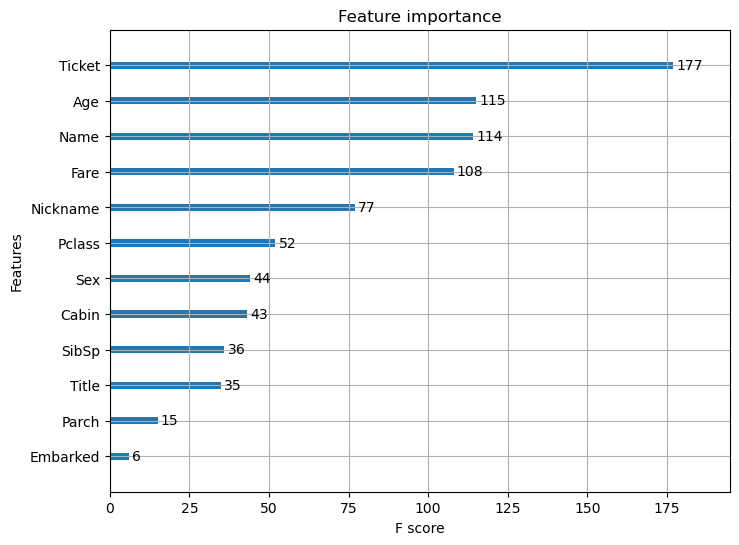

In [503]:
plot_importance(clf)
plt.show()

In [259]:
## I would assume "NAME", "TICK", are over fitting...

## Neil's Custome Pipeline

In [249]:
#load_data()

#target = train["Survived"]
#categorical = ['Pclass','Name','Sex','Ticket','Cabin','Embarked']
#ordinal = ['Age','SibSp','Parch','Fare']
#drop_columns = ["SibSp","Cabin","Ticket","Parch"]

#define features
#features = feature_selection(cols_to_drop, cat_cols, num_cols)
#train = train[features] 
#test = test[features]